## Is Science Becoming Less Disruptive?

* This is a project created in the context of the course: "Applied Machine Learning". <br>
* In this assignment we will create a Machine Learning model that can predict, as accurately as possible, the CD5 of a published paper. <br>
* The analysis will be done on Jupyter

---
>Evangelia P. Panourgia, Data Scientist <br>
>Id : t8190130 <br>
>Department of Management Science and Technology <br>
>Athens University of Economics and Business <br>
>eva.panourgiaa@gmail.com <br>

## Setting the Scene

* To start with, we will import the packages that needed for the notebook. 
* Note that the prementioned packages must be locally installed too in order to be used.

In [5]:
# libaries for the analysis  
import pandas as pd
import numpy as np

# general libraries 
import re
import warnings
import itertools
warnings.filterwarnings('ignore')
import string 
from collections import Counter
import os # linux - windows read file

# nlp preprocess 
from nltk.stem import WordNetLemmatizer
from langdetect import detect
import nltk # tokenization 
import spacy

# for plotting 
import matplotlib.pyplot as plt

# sklearn models && evaluation 
import sklearn
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate

# Technique for overcoming the Imbalanced problem  
from imblearn.over_sampling import SMOTE

# statistics
import statsmodels.api as sm

# Advanced Trees Packages 
import xgboost as xgb
import lightgbm as lgb

## Downloading  Data

* To start with we will download data from the url that exist in our assignment (`https://auebgr.sharepoint.com/sites/AppliedMachineLearning2022/Class%20Materials/Forms/AllItems.aspx?id=%2Fsites%2FAppliedMachineLearning2022%2FClass%20Materials%2Fpublications%5Fgraph%2Edb%2E7z&parent=%2Fsites%2FAppliedMachineLearning2022%2FClass%20Materials&p=true&ga=1`). <br>
* We will unzip the data (**publications_graph.db.7z**) to file:**publications_graph.db\publications_graph.db**<br> 
* We can observe our data are a **db** (means database) file. <br>
* In addition, bearing in mind the assignment, the data derived from the excellent [alexandria3k package](https://github.com/dspinellis/alexandria3k) written by [Professor Diomidis Spinellis](https://www2.dmst.aueb.gr/dds/) and they are in the form of an [SQLite](https://www.sqlite.org/) database.<br>
* So, we needed to **downloaded** locally **sqlight3** (**https://www.sqlite.org/download.html**).
* Having setting the scene, we apllied in our terminal some of the command from the following site: `https://www.sqlitetutorial.net/sqlite-export-csv/` <br>


>sqlite3 c:/Evangelia/publications_graph.db/publications_graph.db<br>
sqlite> .headers on <br>
sqlite> .mode csv <br>
sqlite> .output name_of_csv_file.csv <br>
sqlite> SELECT * FROM replace_with_name_of_table
sqlite> .quit <br>

* Note_1 : For the command that related to output (.output name_of_csv_file.csv) we replace it  with the names of corresponding tables. we find the name of tables with the command:  <br>
`sqlite> .tables` <br>
The given tables are:  
    * `author_affiliations` <br>
    * `cdindex` <br>
    * `work_authors` <br>
    * `work_references` <br>
    * `work_subjects` <br>
    * `works` <br>
So, we have the following generated csv files - outputs: 
    * `author_affiliations.csv` <br>
    * `cdindex.csv` <br>
    * `work_authors.csv` <br>
    * `work_references.csv` <br>
    * `work_subjects.csv` <br>
    * `works.csv` <br>
* Note_2 : For the command that related to select,from , having the name of tables with the command that we mentioned
(`sqlite> .tables`) we can replace the name of table for **FROM** sql comamnd.<br>
* For cdinex we merged it with works table, only with the data that inner joined match with id because we want to exist cdindex, (save space and time). 
    * sqlite command: `select * from cdindex inner join works on cdindex.doi = works.doi;` 
    * Then anme of cdv stemming from this inner join is : `merged_works.csv`


## Understanding the Data
* We can observe from the below database schema the way that the tables related. So, we can understand the way that we will merge the tables, for exampel for **works** and  **work authors** yhe key are: `id` for works and `work_id` for work authors.  
* In our case, in our dataset, we have the tables : 
    * works (with cdindex), 
    * work authors, 
    * author affiliation, 
    * work referencies, 
    * work subjects.
* Source of Image: [url](https://dspinellis.github.io/alexandria3k/schema.html).

![SNOWFALL](schema.jpg)

* Storing the Data to Data Frames. 

In [6]:
path1 = os.path.abspath("data/author_affiliations.csv") 
df_author_affiliations = pd.read_csv(path1)

path2 = os.path.abspath("data/work_authors.csv") 
df_work_authors = pd.read_csv(path2)

path3 = os.path.abspath("data/work_references.csv") 
df_work_references = pd.read_csv(path3)

path4 = os.path.abspath("data/work_subjects.csv") 
df_subjects = pd.read_csv(path4)

path5 = os.path.abspath("data/works.csv") 
df_works = pd.read_csv(path5)

merged = pd.read_csv('merged_works_cdindex.csv')

# Data Exploration 

* Firstly, we will start exploring the table **merged** that is the merged table with **works** and **cdindex**.
* Let's preview it.

In [7]:
merged

,doi,cdindex,id,published_month,abstract,title,published_day,doi.1,published_year
0,10.1016/s0924-9338(99)80691-9,-0.010811,4491329,12.0,<jats:title>Summary</jats:title><jats:p>There ...,Retinitis pigmentosa and schizophrenia,NaN,10.1016/s0924-9338(99)80691-9,1998
1,10.1007/s100249900027,-0.007576,4489260,5.0,<jats:p> The possible effects of a wide range ...,Epidemiology of Intrathoracic Petechial Hemorr...,NaN,10.1007/s100249900027,1998
2,10.1590/s0073-47212013000300013,-0.100000,4477724,9.0,<jats:p>The nymphal instars I and III - V of S...,The nymphs of Sigara (Tropocorixa) denseconscr...,NaN,10.1590/s0073-47212013000300013,2013
3,10.2166/ws.2013.162,1.000000,4477596,9.0,<jats:p>A new approach by combining bioindicat...,"Heterogeneity of water quality in Huai River, ...",12.0,10.2166/ws.2013.162,2013
4,10.1152/ajpendo.00421.2013,-0.000258,4477521,1.0,"<jats:p>Scavenger receptor class B, type I (SR...",The atherogenic<i>Scarb1</i>null mouse model s...,1.0,10.1152/ajpendo.00421.2013,2014
...,...,...,...,...,...,...,...,...,...
137636,10.5005/jp-journals-10028-1097,0.000000,4048568,NaN,<jats:title>ABSTRACT</jats:title>\n<jats:sec>\...,Sublingual vs Oral Misoprostol for Labor Induc...,NaN,10.5005/jp-journals-10028-1097,2014
137637,10.2298/sarh1312794a,1.000000,4048611,NaN,<jats:p>Introduction. Family planning is an im...,Family planning among women in urban and rural...,NaN,10.2298/sarh1312794a,2013
137638,10.1525/ch.2014.91.1.10,NaN,4048903,NaN,<jats:p>Author surveys the work of historian A...,A California History “No Longer Local”,NaN,10.1525/ch.2014.91.1.10,2014
137639,10.2478/s13382-014-0222-7,1.000000,4048990,1.0,<jats:title>Abstract</jats:title>,Plasma thyroid hormones and corticosterone lev...,1.0,10.2478/s13382-014-0222-7,2014


* We will sellect only the columns that we will use to our analysis. 

In [8]:
df_overall=merged[["id","published_year", # define column we will use 
                   "abstract","title",
                   "doi","cdindex"]]

* We will check the shape of the dataframe.

In [9]:
df_overall.shape

(137641, 6)

* We can observe that there are **137641** rows. 
* We will check for missing values 

In [10]:
df_overall.isnull().sum()

id                    0
published_year        0
abstract              0
title                10
doi                   0
cdindex           57360
dtype: int64

* We will drop the missing values for cdindex. 
* And we will reset the index of DataFrame. 

In [11]:
df_overall = df_overall[df_overall['cdindex'].notna()]
df_overall.reset_index(inplace = True)

* We will check the dtype of the DataFrame.

In [12]:
df_overall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80281 entries, 0 to 80280
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           80281 non-null  int64  
 1   id              80281 non-null  int64  
 2   published_year  80281 non-null  int64  
 3   abstract        80281 non-null  object 
 4   title           80278 non-null  object 
 5   doi             80281 non-null  object 
 6   cdindex         80281 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 4.3+ MB


* **NOTE**: In case that you want to **save time** you can omit the next whole section named 
    **Nlp preprocess for Abstract and Title Fields** and go directly to the section **Feature Engineering**.
* In Feature Engineering we read **csv** with preperocess nlp to speed up without needed to run nlp preprocess agin that require some time. 

# Nlp preprocess for Abstract and Title Fields

* In this section, we will apply nlp preprocess for the abstract and title column based on Suplementary Instractions of the paper Nature ( [Supplementary](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-022-05543-x/MediaObjects/41586_2022_5543_MOESM1_ESM.pdf), page 3). 
* Firstly, we will remove the html tags using regexes.

In [13]:
# Source: https://stackoverflow.com/questions/25292838/applying-regex-to-a-pandas-dataframe
# Source: https://stackoverflow.com/questions/45999415/removing-html-tags-in-pandas
def split_it(text): return re.sub('<[^<]+?>', ' ', text)
df_overall["abstract"] = df_overall["abstract"].apply(split_it)

* Then, we will detect the language that are written the title and the abstract, seperately. 
* If an abstract or title is written to diffrent language that english will be removed from our datagrame. In other words the language wll be a filter.  

In [14]:
# Title detection of language 
language_title = []
for i in range(df_overall.shape[0]):
    try:language_title.append(detect(df_overall['title'][i]))
    except(Exception): language_title.append('nan')

# Abstract detection language 
language_abstract = []
for i in range(df_overall.shape[0]):
    try: language_abstract.append(detect(df_overall['abstract'][i]))
    except(Exception): language_abstract.append('nan')

# Apply as columns
df_overall['language_abstract'] = language_abstract
df_overall['language_title'] = language_title

* Next, we will apply tokenization to both abstract and titles. 

In [15]:
# Source: https://datascience.stackexchange.com/questions/67989/tokenization-of-data-in-dataframe-in-python
df_overall['abstract_tokenized'] = df_overall.apply(lambda row: nltk.word_tokenize(row['abstract']), axis=1)
df_overall['title'] = df_overall['title'].astype(str)
df_overall['title_tokenized'] = df_overall.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)

* Next, we will apply stopping words. 

In [16]:
nlp = spacy.load('en_core_web_sm')
all_stopwords = nlp.Defaults.stop_words
df_overall['title_tokenized_st']=df_overall.title_tokenized.apply(lambda x: [w for w in x if not w in all_stopwords])
df_overall['abstract_tokenized_st']=df_overall.abstract_tokenized.apply(lambda x: [w for w in x if not w in all_stopwords])

* Next we will remove the digits. 

In [17]:
#  for abstract
list1 = []
for i in range(df_overall.shape[0]):
    no_integers = [x for x in df_overall.abstract_tokenized_st[i] if not any(c.isdigit() for c in x)]
    list1.append(no_integers)
    
# for title 
list2 = []
for i in range(df_overall.shape[0]):
    no_integers = [x for x in df_overall.title_tokenized_st[i] if not any(c.isdigit() for c in x)]
    list2.append(no_integers)
# apply to DataFrame 
df_overall['title_tokenized_st_d'] = list2
df_overall['abstract_tokenized_st_d'] = list1

* Next, we will apply punctuations 

In [18]:
# title 
panc1 = []
for i in range(df_overall.shape[0]):
    
    x = [''.join(c for c in s if c not in string.punctuation) for s in df_overall['title_tokenized_st_d'][i]]
    x = [s for s in x if s]
    panc1.append(x)

# abstract
panc2 = []
for i in range(df_overall.shape[0]):
    
    x = [''.join(c for c in s if c not in string.punctuation) for s in df_overall['abstract_tokenized_st_d'][i]]
    x = [s for s in x if s]
    panc2.append(x)

# apply to the dataframe 
df_overall['title_tokenized_st_d_p'] = panc1
df_overall['abstract_tokenized_st_d_p'] = panc2

* Apply filter characters less than 250 and more that 3 

In [19]:
# length remove Source: https://stackoverflow.com/questions/45650573/python-deleting-a-string-object-in-a-list-based-on-the-length

# title 
l1 = []
for i in range(df_overall.shape[0]):
    
    lenght = [i for i in df_overall['title_tokenized_st_d_p'][i] if len(i) >3 and len(i)<250]
    l1.append(lenght)

# abstarct 
l2 = []
for i in range(df_overall.shape[0]):
    
    lenght = [i for i in df_overall['abstract_tokenized_st_d_p'][i] if len(i) >3 and len(i)<250]
    l2.append(lenght)

# apply to the dataframe
df_overall['title_tokenized_st_d_p'] = l1
df_overall['abstract_tokenized_st_d_p'] = l2

* Apply lemmatization

In [20]:
# for the abstract 
lemma= WordNetLemmatizer()

ex2 = []

for i in range(df_overall['abstract_tokenized_st_d_p'].shape[0]):
    lem1=[]
    
    for r in df_overall['abstract_tokenized_st_d_p'][i]:
        lem1.append(lemma.lemmatize(r))
    ex2.append(lem1)

# for the title 
lemma= WordNetLemmatizer()
ex1 = []
for i in range(df_overall['title_tokenized_st_d_p'].shape[0]):
    lem2=[]
    
    for r in df_overall['title_tokenized_st_d_p'][i]:
        lem2.append(lemma.lemmatize(r))
    ex1.append(lem2)

# apply to df 
df_overall['title_tokenized_st_d_p_lim'] = ex1
df_overall['abstract_tokenized_st_d_p_lim'] = ex2

* Apply lower letters. 

In [21]:
# title 
lower_1 = []
for i in range(df_overall['title_tokenized_st_d_p_lim'].shape[0]):
    low = [x.lower() for x in df_overall['title_tokenized_st_d_p_lim'][i]]
    lower_1.append(low)

# abstract 
lower_2 = []
for i in range(df_overall['abstract_tokenized_st_d_p_lim'].shape[0]):
    low = [x.lower() for x in df_overall['abstract_tokenized_st_d_p_lim'][i]]
    lower_2.append(low)

# apply to df
df_overall['title_tokenized_st_d_p_low'] = lower_1
df_overall['abstract_tokenized_st_d_p_low'] = lower_2

* Filtering via language (English Language Only) 

In [22]:
# # Performing the operation
df_overall = df_overall[df_overall['language_abstract'] == 'en']
df_overall = df_overall[df_overall['language_title'] == 'en']
df_overall

,index,id,published_year,abstract,title,doi,cdindex,language_abstract,language_title,abstract_tokenized,...,title_tokenized_st,abstract_tokenized_st,title_tokenized_st_d,abstract_tokenized_st_d,title_tokenized_st_d_p,abstract_tokenized_st_d_p,title_tokenized_st_d_p_lim,abstract_tokenized_st_d_p_lim,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low
0,0,4491329,1998,Summary There have been previous suggestions...,Retinitis pigmentosa and schizophrenia,10.1016/s0924-9338(99)80691-9,-0.010811,en,en,"[Summary, There, have, been, previous, suggest...",...,"[Retinitis, pigmentosa, schizophrenia]","[Summary, There, previous, suggestions, litera...","[Retinitis, pigmentosa, schizophrenia]","[Summary, There, previous, suggestions, litera...","[Retinitis, pigmentosa, schizophrenia]","[Summary, There, previous, suggestions, litera...","[Retinitis, pigmentosa, schizophrenia]","[Summary, There, previous, suggestion, literat...","[retinitis, pigmentosa, schizophrenia]","[summary, there, previous, suggestion, literat..."
1,1,4489260,1998,The possible effects of a wide range of soci...,Epidemiology of Intrathoracic Petechial Hemorr...,10.1007/s100249900027,-0.007576,en,en,"[The, possible, effects, of, a, wide, range, o...",...,"[Epidemiology, Intrathoracic, Petechial, Hemor...","[The, possible, effects, wide, range, sociodem...","[Epidemiology, Intrathoracic, Petechial, Hemor...","[The, possible, effects, wide, range, sociodem...","[Epidemiology, Intrathoracic, Petechial, Hemor...","[possible, effects, wide, range, sociodemograp...","[Epidemiology, Intrathoracic, Petechial, Hemor...","[possible, effect, wide, range, sociodemograph...","[epidemiology, intrathoracic, petechial, hemor...","[possible, effect, wide, range, sociodemograph..."
2,2,4477724,2013,The nymphal instars I and III - V of Sigara (...,The nymphs of Sigara (Tropocorixa) denseconscr...,10.1590/s0073-47212013000300013,-0.100000,en,en,"[The, nymphal, instars, I, and, III, -, V, of,...",...,"[The, nymphs, Sigara, (, Tropocorixa, ), dense...","[The, nymphal, instars, I, III, -, V, Sigara, ...","[The, nymphs, Sigara, (, Tropocorixa, ), dense...","[The, nymphal, instars, I, III, -, V, Sigara, ...","[nymphs, Sigara, Tropocorixa, denseconscripta,...","[nymphal, instars, Sigara, Tropocorixa, densec...","[nymph, Sigara, Tropocorixa, denseconscripta, ...","[nymphal, instar, Sigara, Tropocorixa, denseco...","[nymph, sigara, tropocorixa, denseconscripta, ...","[nymphal, instar, sigara, tropocorixa, denseco..."
3,3,4477596,2013,A new approach by combining bioindicators (Bi...,"Heterogeneity of water quality in Huai River, ...",10.2166/ws.2013.162,1.000000,en,en,"[A, new, approach, by, combining, bioindicator...",...,"[Heterogeneity, water, quality, Huai, River, ,...","[A, new, approach, combining, bioindicators, (...","[Heterogeneity, water, quality, Huai, River, ,...","[A, new, approach, combining, bioindicators, (...","[Heterogeneity, water, quality, Huai, River, C...","[approach, combining, bioindicators, biotic, i...","[Heterogeneity, water, quality, Huai, River, C...","[approach, combining, bioindicators, biotic, i...","[heterogeneity, water, quality, huai, river, c...","[approach, combining, bioindicators, biotic, i..."
4,4,4477521,2014,"Scavenger receptor class B, type I (SR-BI), t...",The atherogenic<i>Scarb1</i>null mouse model s...,10.1152/ajpendo.00421.2013,-0.000258,en,en,"[Scavenger, receptor, class, B, ,, type, I, (,...",...,"[The, atherogenic, <, >, Scarb1, <, /i, >, nul...","[Scavenger, receptor, class, B, ,, type, I, (,...","[The, atherogenic, <, >, <, /i, >, null, mouse...","[Scavenger, receptor, class, B, ,, type, I, (,...","[atherogenic, null, mouse, model, shows, high,...","[Scavenger, receptor, class, type, SRBI, gene,...","[atherogenic, null, mouse, model, show, high, ...","[Scavenger, receptor, class, type, SRBI, gene,...","[atherogenic, null, mouse, model, show, high, ...","[scavenger, receptor, class, type, srbi, gene,..."
...,...,...,...,...,...,...,...,...,.

* Sellect only the needed columns for our analysis. 

In [23]:
df = df_overall[['id','published_year', # sellect needed columns 
                 'doi','title_tokenized_st_d_p_low',
                 'abstract_tokenized_st_d_p_low','cdindex']]

* Let's preview the DataFrame (We will sort the year).

In [24]:
df = df.sort_values('published_year')
df 

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex
51864,1623830,1946,10.1017/s0003598x00019207,"[pleistocene, chronology, east]","[anthropologist, dating, fossil, remains, preh...",1.000000
63685,100542,1947,10.1177/004051754701700802,"[hydrolysis, native, versus, regenerated, cell...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429
10151,1541524,1948,10.1017/s0373463300034494,"[altitude, corrections, coriolis, other, accel...","[some, apology, adequate, excuse, needed, resu...",1.000000
40734,1545008,1948,10.1017/s0373463300034512,"[i—elementary, theory, underlying, pressure, p...","[pressure, pattern, flying, embrace, number, n...",1.000000
11592,4177939,1948,10.1090/qam/24251,"[approximate, numerical, solution, nonhomogene...","[relaxation, method, applied, problem, finding...",1.000000
...,...,...,...,...,...,...
69249,3147677,2021,10.1186/s13063-021-05225-5,"[monitoring, advance, including, consent, lear...","[abstract, pandemic, affected, clinical, trial...",-0.250000
69250,3147683,2021,10.1200/cci.20.00163,"[electronic, geriatric, assessment, feasible, ...","[purpose, this, study, determined, electronic,...",0.000000
69251,3147692,2021,10.3390/antibiotics10040437,"[next, generation, sequencing, prediction, ant...","[background, aim, only, antimicrobial, effecti...",-0.000869
69241,3147610,2021,10.1039/d1ra00484k,"[particle, ndoped, porous, carbon, material, d...","[zifderived, bifunctional, electrocatalysts, o...",0.000000


* Remove years more that **2017** becase cd5 calculated for the window of five years.

In [25]:
df = df[df.published_year <=2017]
df

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex
51864,1623830,1946,10.1017/s0003598x00019207,"[pleistocene, chronology, east]","[anthropologist, dating, fossil, remains, preh...",1.000000
63685,100542,1947,10.1177/004051754701700802,"[hydrolysis, native, versus, regenerated, cell...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429
10151,1541524,1948,10.1017/s0373463300034494,"[altitude, corrections, coriolis, other, accel...","[some, apology, adequate, excuse, needed, resu...",1.000000
40734,1545008,1948,10.1017/s0373463300034512,"[i—elementary, theory, underlying, pressure, p...","[pressure, pattern, flying, embrace, number, n...",1.000000
11592,4177939,1948,10.1090/qam/24251,"[approximate, numerical, solution, nonhomogene...","[relaxation, method, applied, problem, finding...",1.000000
...,...,...,...,...,...,...
42388,346497,2017,10.1017/s0957423916000096,"[yaḥyā, ʿadī, ibrāhīm, ʿadī, whether, body, su...","[abstract, lost, yaḥyā, ʿadī, treatise, recent...",0.013889
17737,903138,2017,10.7554/elife.26796,"[multiple, source, slow, activity, fluctuation...","[cellular, network, intrinsically, subject, st...",-0.002455
45530,937088,2017,10.1542/hpeds.2016-0180,"[detection, acute, gastroenteritis, etiology, ...","[background, decision, test, etiology, diarrhe...",0.001626
63040,904338,2017,10.1177/1471301217740005,"[achieving, positive, outcome, complex, case, ...","[carer, distress, common, factor, caring, deme...",0.000000


* We will reset the index 
* We will save the data to a csv so as we speed up the process as we needed to run many times the jupyter.
* We will check for duplicates values.

In [26]:
df.reset_index(inplace = True)
df

,index,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex
0,51864,1623830,1946,10.1017/s0003598x00019207,"[pleistocene, chronology, east]","[anthropologist, dating, fossil, remains, preh...",1.000000
1,63685,100542,1947,10.1177/004051754701700802,"[hydrolysis, native, versus, regenerated, cell...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429
2,10151,1541524,1948,10.1017/s0373463300034494,"[altitude, corrections, coriolis, other, accel...","[some, apology, adequate, excuse, needed, resu...",1.000000
3,40734,1545008,1948,10.1017/s0373463300034512,"[i—elementary, theory, underlying, pressure, p...","[pressure, pattern, flying, embrace, number, n...",1.000000
4,11592,4177939,1948,10.1090/qam/24251,"[approximate, numerical, solution, nonhomogene...","[relaxation, method, applied, problem, finding...",1.000000
...,...,...,...,...,...,...,...
44128,42388,346497,2017,10.1017/s0957423916000096,"[yaḥyā, ʿadī, ibrāhīm, ʿadī, whether, body, su...","[abstract, lost, yaḥyā, ʿadī, treatise, recent...",0.013889
44129,17737,903138,2017,10.7554/elife.26796,"[multiple, source, slow, activity, fluctuation...","[cellular, network, intrinsically, subject, st...",-0.002455
44130,45530,937088,2017,10.1542/hpeds.2016-0180,"[detection, acute, gastroenteritis, etiology, ...","[background, decision, test, etiology, diarrhe...",0.001626
44131,63040,904338,2017,10.1177/1471301217740005,"[achieving, positive, outcome, complex, case, ...","[carer, distress, common, factor, caring, deme...",0.000000


* Check for duplicates values 

In [27]:
pd.Series(df["id"]).is_unique

True

* Pay attention we will use two times in this jupyter checkpoints to save time. 
* The first point is here because we want not to repeat cleaning and nlp process. 
* The other time is before Feature Engineering so as to have ready the data for Google Colab to run our neural network.
* So, these lines of code for checkpoints are in comments. 
* If you decided to rerun these comments commands sometimes 1 / 3 times I observed that the final dataframe that we will run the model have a little fewer data and as a result the observations for example for MAE may be a very little changable from 0.040 to 0.039.
    * Unfortunately, I cannot understand why sometimes the general dataframe before running regression models or NN is deffrent for a vey few lines but these lines have a very very small impact on the MAE or Max depth from 6 to 7 depth.
* So, it would be a good idea to simply read the generated checkpoints and not reproduce them to avoid the small problem and my comments are extremely accuarate with the scores etc.

In [28]:
# df.drop(['index'], axis=1, inplace=True) 
# df.to_csv('nlp_process_cleaning_FINAL.csv') # checkpoint save data to read them directly withoyt needed to tun all cells for preproces :)

## Feature Engineering 
* We read the data from csv that have saved all the previous nlp and cleaning preprocess so as to speed up the time.
* The command **pd.eval** holds the initial dtype of the dataframe. 

In [29]:
import pandas as pd 
d = pd.read_csv('nlp_process_cleaning_FINAL.csv', 
                converters={'abstract_tokenized_st_d_p_low': pd.eval},encoding='utf-8')
# drop useless column 
d.drop(['Unnamed: 0'], axis=1, inplace=True)
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000
...,...,...,...,...,...,...
44152,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106
44153,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105
44154,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514
44155,1983283,2017,10.31227/osf.io/c3qud,"['combination', 'blowfish', 'lempelzivwelch', ...","[this, postprint, version, paper, published, w...",1.000000


## First Feature : [Ratio = Unique Words / Total Words]
* Creating the ratio `unique words / total` only for the **abstract column** words bearing in mind the previous years because we don't want the model to learn the future data.
* Note : The idea based on the instructions of Suplimentary paper. 
* Because we wanted to speed up the calculation of the ratio `unique words / total words` we created pointers for each year group and we hold only the first index of the each group and the last index. In addition, we stored how many elements exist in each group. 

In [30]:
df_copy = d.copy()

# Find the pointers to speed up 
POINTERS = d.sort_values(by="published_year").drop_duplicates(subset=["published_year"], keep="last").index.tolist()
import numpy as np
POINTERS_first = d.sort_values(by="published_year").drop_duplicates(subset=["published_year"], keep="first").index.tolist()
                                                                                                    # pointer for the index 
POINTERS_last = d.sort_values(by="published_year").drop_duplicates(subset=["published_year"], keep="last").index.tolist()
                                                                                                    # pointer for the index
list_range = []
def merge(list1, list2):
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list

list1 = POINTERS_first
list2 = POINTERS_last
POINTER = merge(list1, list2)
list_how = []

for i in range(len(POINTER)):
    f = POINTER[i][0]
    l = POINTER[i][1]
    counter = 0
    while f <= l:
        counter = counter + 1 
        f = f + 1
    list_how.append(counter)


* The logic behind this code is the following one: 
    * Initialize `word_check_flat_ls` which contains the words that each time we check for each row of the dataframe if the current word of abstract is **in**.in. If it is in the list it is not unique.
    * We update this list based on the pointers and the elements that exist in each group. For example, if we have pointer = (1,3) and  how_many = 3 then for the loop from index 1 to 3 we will not update the list `word_check_flat_ls`.
    * Furthermore, for each row we will check for each word of abstract if there is in the list if not in list then we increase the inner counter and external counter otherwise we increase only the external counter.
* Finally, we will save the new calculated ratio = (unique_yords / total words) to the already dataframe in the new column named **ratio**.  

In [31]:
def calculate_ratio(first: list, last:list, range_number:int) -> 'list':
    """
    This Function returns a list with the ratio = unique words / total words for each abstract.
    """
    # Initialize Varibles and data stractures 
    global index 
    index = 0
    words_check, ratio, word_check_flat_ls = [], [], []
    
    for fill_with_1 in range(range_number):
        ratio.append(1) 
    
    for i in range(d.shape[0]):

        # 1. Update list words_check
        if i in first and i !=0: 
            list1 = d[i-list_how[index]:i].abstract_tokenized_st_d_p_low.tolist()                
            index = index + 1 
            words_new = list(itertools.chain(*list1))
            words_check.append(words_new)
            word_check_flat_ls = [item for sublist in words_check for item in sublist] # extend, flat the list 

        # 2. Check if teh words of the abstract for i-th itteration exist in the list: words_check.   
        if i > 0: # upper bound first index         
            current_list_abstract = df_copy.abstract_tokenized_st_d_p_low[i] # for each word of current abstract
            external = 0 # counter external (always it is inceased)
            inner = 0 # counter internal (taht is, not in list)
            for k in range(len(current_list_abstract)):
                if current_list_abstract[k] not in word_check_flat_ls:
                    inner = inner + 1
                external = external + 1
            try: 
                ratio.append(inner / external) # strore ratio = unique words / total words
            except(Exception):
                print('opps devision with 0!') # devide with zero 
    
    return ratio

d['ratio'] = calculate_ratio(POINTERS_first, 
                             POINTERS_last,
                             range_number = 1)  # 1, because for the smallest year of the dataframe we have only one row  

* Graphical Represenation 

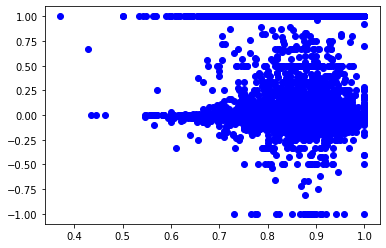

In [32]:
# see correlation 
cd = d.cdindex
ratio_metric = d.ratio
plt.scatter(ratio_metric, cd,c ="blue")
# To show the plot
plt.show()

* In the above figure we can see a graphical represenation in **x'x** :: `ratio` and **y'y** :: `cdindex` values [-1,1].

* Extend the first feature by replacing with 1 the ratio if exist at least one innoation word either in **title** or **abstract**.
* We will define a set with innovation terminology (verbs, nouns) having as main direction the verbs that mentioned in the paper of Nature.  

In [33]:
# create innovation terminology 
set_innovation = ('create', 'creation', 'produce', 
                  'production','invent','invention', 
                  'develop', 'development', 'manufacture', # words for create
                    'discover', 'discovery', 'uncover' # words for discover 
                     'observe', 'observation', 'identify',
                  'identification','understand', 'understanding',
                  'comprehend', 'comrehension'# for perception
                 ) 

In [34]:
# abstract 
ranking_abstract = []
for i in range(d.shape[0]): 
    flag = False
    for j in d.abstract_tokenized_st_d_p_low[i]:
        if j in set_innovation:
            flag = True 
    ranking_abstract.append(flag)
d['abstract_innovation'] = ranking_abstract
# title 
ranking_title = []
for i in range(d.shape[0]): 
    flag = False
    for j in d.title_tokenized_st_d_p_low[i]:
        if j in set_innovation:
            flag = True 
    ranking_title.append(flag)
d['title_noovation'] = ranking_title

# column for innovation filter 
list_innovation = []
for i in range(d.shape[0]):
    if (d.abstract_innovation[i] == True) | (d.title_noovation[i] == True):
        list_innovation.append(1)
    else: 
        list_innovation.append(0)
d['innpvation'] = list_innovation

# drop useless columns 
d.drop('abstract_innovation',axis=1,inplace=True)
d.drop('title_noovation',axis=1, inplace=True)

In [35]:
d['ratio_initial'] = d['ratio'] 

* For the rows taht either title or abstract conatin at least one innovative word we will replace the corresponding `ratio` values with 1.

In [36]:
# reaplace ration with 1 when innovation 
d['ratio'].loc[d['innpvation']==1] = 1

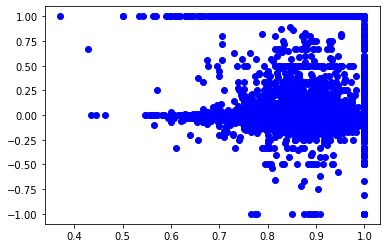

In [37]:
# see correlation 
cd = d.cdindex
ra = d.ratio
import matplotlib.pyplot as plt
plt.scatter(ra, cd,c ="blue")
# To show the plot
plt.show()

* Here, we can see how ratio - cdindex values changed a bit.  

* Now we will calculate some simple metrics stemming from the joins and groupby of our tables.

## Second feature how many references each paper : [Referencies]

* The second features is how many refrencies exist in a paper. 
* We will join with **left** because we don't want to lose data. At the beggining we applied inner join but at the end we had fewer data and so we decided to use left join to have more data and generate better results (MAE).
* We calculate applying groupby in our merge table stemming from left join to see how many refrencies exist.
* In addition we detect the unmatched keys (stemming from left join).
* And we will corect the calculations for unmatched keys with the value of 0 afterwards. Because if we don't correct  them they will have the value 1 from the group by, wchich is wrong.
    * Note this trick for left join is done for having more data
    * the detection of unmatched keys will be ddone in other features,too
    * and we will correc  them we the same trick replace with 0 the unmatched keys, so next we will not explain it again but the trick has the same logic.

In [38]:
df_work_references[df_work_references.work_id == 1623830] # this is a row for showing the unmatcehd id .

,article_title,year,work_id,doi


In [39]:
d[d.id == 1623830]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.0,1.0,0,1.0


* We will apply left join on the common key **id**.

In [40]:
for_these_values_0 = d.merge(df_work_references,left_on='id',right_on='work_id',how='left')

* We will detect unmatched keys. 

In [41]:
replace_0 = for_these_values_0[for_these_values_0.work_id.isnull()]
replace_0 = replace_0[['id']]
replace_0 # for this id put 0 

,id
0,1623830
21,1541524
26,1545008
64,2835073
66,1541352
...,...
1135853,117768
1135866,1985425
1135935,3589871
1135974,1985403


In [42]:
replace_0_list = replace_0['id'].tolist()

* In the new merged table we will apply group by to see each paper how many refrencies has.
* The result of groupby we will convert it to dataframe (reset) and we will rename the column from 0 to refrencies

In [43]:
refrencies_ech_paper = d.merge(df_work_references,left_on='id',right_on='work_id',how='left')
group_how_many_refs = refrencies_ech_paper.groupby('id').size()
# here times correct 
group_how_many_refs = pd.DataFrame(group_how_many_refs) # Create DataFrame
group_how_many_refs.reset_index(level=0, inplace=True) # make index --> column 
group_how_many_refs.rename(columns = {0:'referencies'}, inplace = True) # rename the column
group_how_many_refs # preview the DataFrame

,id,referencies
0,171,23
1,239,5
2,284,59
3,299,66
4,373,25
...,...,...
44152,4477596,1
44153,4477724,25
44154,4489260,40
44155,4490759,24


* Using group by we managed to calculate how many refrensies exist in a papper
* For example for the paper with id 171 tehre are 23 refrencies
*Then we will merge inner join teh group by dataframe with the whole **d** dataframe to have the whole information together. 

In [44]:
group_how_many_refs[group_how_many_refs.id == 1623830]

,id,referencies
20893,1623830,1


In [45]:
d = d.merge(group_how_many_refs, on='id', how='inner')
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,1
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429,0.968254,0,0.968254,11
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000,1.000000,1,0.973333,1
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000,0.880000,0,0.880000,4
...,...,...,...,...,...,...,...,...,...,...
44152,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106,0.833333,0,0.833333,44
44153,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105,0.845238,0,0.845238,43
44154,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514,0.936000,0,0.936000,21
44155,1983283,2017,10.31227/osf.io/c3qud,"['combination', 'blowfish', 'lempelzivwelch', ...","[this, postprint, version, paper, published, w...",1.000000,0.846154,0,0.846154,1


In [46]:
d[d.id == 1623830]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.0,1.0,0,1.0,1


In [47]:
len(replace_0_list)

12248

* And, finally, we will correct the unmatched keys with 0 as we said at the beggining. 

In [48]:
d.loc[(d['id'].isin(replace_0_list)), 'referencies'] = 0

In [49]:
d[d.id == 1623830]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.0,1.0,0,1.0,0


* We see that we corrected the unmatched key with 0, you can llok the column :: refrencies..

In [50]:
d.doi.is_unique

True

## Third feature: [How many Fields each  Paper]

* We will calculate how many subjects exist for each papers.
* Again we will applay left join, Groupby -> we will convert from index to dataframe so as to merge it with the whole dataframe d, and we will correct the unmatched keys with 0. 

In [51]:
replace_with_0_3 = field_paper = d.merge(df_subjects,left_on='id',right_on='work_id',how='left')
replace_with_0_3 = replace_with_0_3[replace_with_0_3.work_id.isnull()]
replace_with_0_3 = replace_with_0_3['id'].tolist()

In [52]:
replace_with_0_3[0:7] # some of the unmatched keys 

[2212772, 1311616, 1311764, 1314269, 1313999, 1312970, 1312413]

In [53]:
df_subjects[df_subjects.work_id == 2212772]

,work_id,name


In [54]:
field_paper = d.merge(df_subjects,left_on='id',right_on='work_id',how='left')
# groupby id 
field_paper = field_paper.groupby('id').size()
roup_fields_paper = pd.DataFrame(field_paper) # Create DataFrame
roup_fields_paper.reset_index(level=0, inplace=True) # make index --> column 
roup_fields_paper.rename(columns = {0:'fields'}, inplace = True) # rename the column
d = d.merge(roup_fields_paper, on='id', how='inner')
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429,0.968254,0,0.968254,11,2
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000,1.000000,1,0.973333,0,2
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000,0.880000,0,0.880000,4,1
...,...,...,...,...,...,...,...,...,...,...,...
44152,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106,0.833333,0,0.833333,44,2
44153,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105,0.845238,0,0.845238,43,1
44154,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514,0.936000,0,0.936000,21,3
44155,1983283,2017,10.31227/osf.io/c3qud,"['combination', 'blowfish', 'lempelzivwelch', ...","[this, postprint, version, paper, published, w...",1.000000,0.846154,0,0.846154,0,1


In [55]:
d[d.id == 2212772]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields
32,2212772,1951,10.1177/003591575104400105,"['soft', 'tissue', 'tumours', 'their', 'natura...","[series, patient, largest, recorded, single, s...",0.0,0.90625,0,0.90625,11,1


In [56]:
# replace with 0 ids specific 
d.loc[(d['id'].isin(replace_with_0_3)), 'fields'] = 0

In [57]:
d[d.id == 2212772]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields
32,2212772,1951,10.1177/003591575104400105,"['soft', 'tissue', 'tumours', 'their', 'natura...","[series, patient, largest, recorded, single, s...",0.0,0.90625,0,0.90625,11,0


## Fourth Feature : [How many authors in each papers]

* We will calculate how many authors exist in each paper.
* Again we will apply left join, group by and we will correct the unmatched keys from left join with 0.

In [58]:
replace_with_0_4 = field_paper = d.merge(df_subjects,left_on='id',right_on='work_id',how='left')
replace_with_0_4 = replace_with_0_4[replace_with_0_4.work_id.isnull()]
replace_with_0_4 = replace_with_0_4['id'].tolist()
replace_with_0_4[0]

2212772

In [59]:
# replace_with_0_4[0:100]

In [60]:
authors_paper = d.merge(df_work_authors,left_on='id',right_on='work_id',how='left')
group_authors_each_paper = authors_paper.groupby('id_x').size()
# # here times correct 
group_authors_each_paper = pd.DataFrame(group_authors_each_paper) # Create DataFrame
group_authors_each_paper.reset_index(level=0, inplace=True) # make index --> column  
group_authors_each_paper.rename(columns = {0:'authors'}, inplace = True) # rename the column
d = d.merge(group_authors_each_paper, left_on='id', right_on='id_x',how='inner')
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,id_x,authors
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2,1623830,1
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,1540683,4
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429,0.968254,0,0.968254,11,2,100542,2
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000,1.000000,1,0.973333,0,2,1541524,1
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000,0.880000,0,0.880000,4,1,4177939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44152,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106,0.833333,0,0.833333,44,2,4179685,8
44153,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105,0.845238,0,0.845238,43,1,3576299,3
44154,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514,0.936000,0,0.936000,21,3,150614,8
44155,1983283,2017,10.31227/osf.io/c3qud,"['combination', 'blowfish', 'lempelzivwelch', ...","[this, postprint, version, paper, published, w...",1.000000,0.846154,0,0.846154,0,0,1983283,1


In [61]:
d.drop('id_x',axis=1,inplace=True)

In [62]:
d[d.id == 2212772]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors
32,2212772,1951,10.1177/003591575104400105,"['soft', 'tissue', 'tumours', 'their', 'natura...","[series, patient, largest, recorded, single, s...",0.0,0.90625,0,0.90625,11,0,1


* See authors value

In [63]:
# replace for secific vlues 
d.loc[(d['id'].isin(replace_with_0_4)), 'authors'] = 0

In [64]:
d[d.id == 2212772]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors
32,2212772,1951,10.1177/003591575104400105,"['soft', 'tissue', 'tumours', 'their', 'natura...","[series, patient, largest, recorded, single, s...",0.0,0.90625,0,0.90625,11,0,0


* See authors values

## Fifth Feature A doi how many times appears in the work_reference table. [How many other papers refereto it ]

* Now, we will calculate the oposite from refrencies. 
* We will see a doi how many times appear in df_work_refrencies table

In [65]:
ref = pd.DataFrame(df_work_references.groupby(['doi']).size())
ref.reset_index(level=0, inplace=True)
ref.rename(columns = {0:'refer'}, inplace = True)
df_with_ref = pd.merge(d, ref, on = "doi", how="left")
d['refer'] = df_with_ref['refer'].fillna(0)
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors,refer
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2,1,0.0
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,4,0.0
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429,0.968254,0,0.968254,11,2,2,0.0
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000,1.000000,1,0.973333,0,2,1,1.0
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000,0.880000,0,0.880000,4,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44152,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106,0.833333,0,0.833333,44,2,8,0.0
44153,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105,0.845238,0,0.845238,43,1,3,0.0
44154,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514,0.936000,0,0.936000,21,3,8,0.0
44155,1983283,2017,10.31227/osf.io/c3qud,"['combination', 'blowfish', 'lempelzivwelch', ...","[this, postprint, version, paper, published, w...",1.000000,0.846154,0,0.846154,0,0,0,0.0


## Sixth Feature: [How many papers have written per Year and per Field (Sum)] 

* For example if a paper belongs to two categories and have written in 2017 we will sum how many papers in total have written in 2017 for the first filed and how many papers have written for the second field in 2017 and we will sum both an we will take the sum of total papers. We have splitted the cells to steps to understand the logic. At the end we have implemented a debug for a random row. 

* Firstly, we will merge with inner join the whole dataframe **d** with the table **df_subjects** that contains the subjects. 
* Then for this new dataframe that created, `times_group`, we will apply froup by to see how many papers exist per year and per subject (column :: **times**).
*  Again the table from groupby will be converted to dataframe (reset).

In [66]:
merged_2 = d.merge(df_subjects,left_on='id',right_on='work_id',how='inner')
times_group = merged_2.groupby(['published_year','name']).size()

# times_group.reset_index(level=0, inplace=True)
times_group = pd.DataFrame(times_group) # Create DataFrame
times_group.reset_index(level=0, inplace=True) # make index --> column 
times_group.reset_index(level=0, inplace=True) # make index --> column 
times_group.rename(columns = {0:'times'}, inplace = True) # rename the column
times_group

,name,published_year,times
0,Archeology,1946,1
1,General Arts and Humanities,1946,1
2,Chemical Engineering (miscellaneous),1947,1
3,"Ecology, Evolution, Behavior and Systematics",1947,1
4,Insect Science,1947,1
...,...,...,...
6991,Urban Studies,2017,9
6992,Virology,2017,18
6993,Visual Arts and Performing Arts,2017,7
6994,Waste Management and Disposal,2017,2


* We will merge groupby result with whole dataframe based on **year** and **name** of sumbject so that to combine properly the dataframes. 

In [67]:
merged_2 = merged_2.merge(times_group, on=['published_year','name'])
merged_2

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors,refer,work_id,name,times
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2,1,0.0,1623830,General Arts and Humanities,1
1,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2,1,0.0,1623830,Archeology,1
2,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,4,0.0,1540683,Insect Science,1
3,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,4,0.0,1540683,Molecular Biology,1
4,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,4,0.0,1540683,Physiology,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95363,935784,2017,10.1177/1084822317728265,"['selfperception', 'social', 'isolation', 'lon...","[there, large, group, older, individual, suffe...",0.000000,0.873016,0,0.873016,14,3,1,0.0,935784,Community and Home Care,1
95364,1901962,2017,10.1055/s-0036-1584403,"['reconstruction', 'cranial', 'vault', 'contou...","[nowadays, reconstruction, craniofacial, defec...",0.025000,0.903846,0,0.903846,15,3,5,0.0,1901962,Oral Surgery,1
95365,150905,2017,10.1142/s0218001417550163,"['multistate', 'selflearning', 'template', 'li...","[multicamera, video, tracking, tracking, scene...",-0.000393,0.836066,0,0.836066,29,3,5,0.0,150905,Computer Vision and Pattern Recognition,2
95366,347268,2017,10.1142/s0218001417550114,"['temporal–spatial', 'symmetric', 'distributed...","[improve, rate, stability, balance, different,...",0.008197,0.894737,0,0.894737,10,3,8,0.0,347268,Computer Vision and Pattern Recognition,2


* Now, because a paper may exist in many subjects we will use group by and sum because we want to sum the **times** column the doi will be done on **doi** column because sum don't chenge string (instead of id).  

In [68]:
s = merged_2.groupby('doi').sum()
s

,id,published_year,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors,refer,work_id,times
doi,,,,,,,,,,,,
10.1002/bjs.10032,1361155,2015,-0.001182,0.924812,0,0.924812,28,1,10,0.0,1361155,28
10.1002/bjs.10224,1311728,2016,-0.015896,0.866667,0,0.866667,25,1,8,0.0,1311728,45
10.1002/bjs.10275,3232052,2016,0.000087,0.920245,0,0.920245,14,1,37,0.0,3232052,45
10.1002/bjs.10674,1446567,2017,-0.000077,0.888060,0,0.888060,59,1,5,0.0,1446567,38
10.1002/bjs.1800831137,263182,1996,-0.002408,0.885417,0,0.885417,21,1,6,0.0,263182,7
...,...,...,...,...,...,...,...,...,...,...,...,...
10.9738/intsurg-d-13-cc194,3771875,2013,1.000000,0.950617,0,0.950617,0,1,10,0.0,3771875,58
10.9738/intsurg-d-15-00036.1,297284,2015,1.000000,0.857143,0,0.857143,0,1,7,0.0,297284,28
10.9740/mhc.2017.09.181,3752520,8068,4.000000,4.000000,4,3.602837,0,16,8,0.0,3752520,108


* We will reset the new table from groupby again.

In [69]:
# times_group = pd.DataFrame(times_group) # Create DataFrame
s.reset_index(level=0, inplace=True) # make index --> column 
s = s[['doi','times']]
s

,doi,times
0,10.1002/bjs.10032,28
1,10.1002/bjs.10224,45
2,10.1002/bjs.10275,45
3,10.1002/bjs.10674,38
4,10.1002/bjs.1800831137,7
...,...,...
40936,10.9738/intsurg-d-13-cc194,58
40937,10.9738/intsurg-d-15-00036.1,28
40938,10.9740/mhc.2017.09.181,108
40939,10.9740/mhc.2017.09.221,108


* Finally, we will merge it with the whole dataframe to have all information together for aour analysis.

In [70]:
d = d.merge(s,on='doi')
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors,refer,times
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2,1,0.0,2
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,4,0.0,5
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429,0.968254,0,0.968254,11,2,2,0.0,2
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000,1.000000,1,0.973333,0,2,1,1.0,4
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000,0.880000,0,0.880000,4,1,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40936,4180901,2017,10.1152/ajprenal.00486.2016,"['target', 'protect', 'aldosteroneinduced', 'p...","[micrornas, essential, maintenance, podocyte, ...",0.000000,0.940000,0,0.940000,38,1,11,0.0,60
40937,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106,0.833333,0,0.833333,44,2,8,0.0,218
40938,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105,0.845238,0,0.845238,43,1,3,0.0,3
40939,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514,0.936000,0,0.936000,21,3,8,0.0,331


* We will apply a soon debug.

In [71]:
# debug this feature 
d

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors,refer,times
0,1623830,1946,10.1017/s0003598x00019207,"['pleistocene', 'chronology', 'east']","[anthropologist, dating, fossil, remains, preh...",1.000000,1.000000,0,1.000000,0,2,1,0.0,2
1,1540683,1947,10.4039/ent79161-9,"['laboratory', 'assessment', 'organic', 'insec...","[recent, development, insecticide, field, avai...",0.000000,1.000000,1,0.970588,9,5,4,0.0,5
2,100542,1947,10.1177/004051754701700802,"['hydrolysis', 'native', 'versus', 'regenerate...","[milder, condition, hydrolysis, heretofore, ge...",-0.071429,0.968254,0,0.968254,11,2,2,0.0,2
3,1541524,1948,10.1017/s0373463300034494,"['altitude', 'corrections', 'coriolis', 'other...","[some, apology, adequate, excuse, needed, resu...",1.000000,1.000000,1,0.973333,0,2,1,1.0,4
4,4177939,1948,10.1090/qam/24251,"['approximate', 'numerical', 'solution', 'nonh...","[relaxation, method, applied, problem, finding...",1.000000,0.880000,0,0.880000,4,1,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40936,4180901,2017,10.1152/ajprenal.00486.2016,"['target', 'protect', 'aldosteroneinduced', 'p...","[micrornas, essential, maintenance, podocyte, ...",0.000000,0.940000,0,0.940000,38,1,11,0.0,60
40937,4179685,2017,10.1039/c6tc04529d,"['nanowire', 'reinforced', 'nanoparticle', 'na...","[novel, nanocomposite, nanowire, reinforced, n...",-0.003106,0.833333,0,0.833333,44,2,8,0.0,218
40938,3576299,2017,10.1108/ijchm-03-2015-0092,"['predicting', 'hospitality', 'firm', 'failure...","[purpose, available, information, evaluating, ...",0.002105,0.845238,0,0.845238,43,1,3,0.0,3
40939,150614,2017,10.1136/acupmed-2016-011139,"['acupuncture', 'upregulates', 'protein', 'cou...","[background, transmembrane, intracellular, sig...",-0.013514,0.936000,0,0.936000,21,3,8,0.0,331


In [72]:
d[d.id == 3690412]

,id,published_year,doi,title_tokenized_st_d_p_low,abstract_tokenized_st_d_p_low,cdindex,ratio,innpvation,ratio_initial,referencies,fields,authors,refer,times
39333,3690412,2017,10.5194/esurf-5-451-2017,"['treeroot', 'control', 'shallow', 'landslide']","[abstract, tree, root, long, recognized, incre...",-0.003058,1.0,1,0.93609,75,2,2,0.0,18


In [73]:
df_subjects[df_subjects.work_id ==3690412] # detect the fields that have the specific doi since 
                                            # it may blongs to more than one subject category 

,work_id,name
197572,3690412,Earth-Surface Processes
197573,3690412,Geophysics


In [74]:
# Logic behind the debug proccess 
# how many papers in **2017** total for teh field ::  Earth-Surface Processes
# how many papers in **2017** total for the field ::  Geophysics

In [75]:
times_group[(times_group.published_year == 2017) & (times_group.name == 'Earth-Surface Processes')]

,name,published_year,times
6785,Earth-Surface Processes,2017,6


In [76]:
times_group[(times_group.published_year == 2017) & (times_group.name == 'Geophysics')]

,name,published_year,times
6848,Geophysics,2017,12


In [77]:
6+12 # Fine!!!!!!!!!verified!!!1

18

* Fine, our result is correct.

* In addition, as feature we hold `published year` column as it is.

In [78]:
all =  d[['published_year','ratio','referencies','cdindex','refer','fields', 'authors','times','doi']]

* We will save our data to a csv named :: `this_is_the_final_csv_for_google_colab.csv`
* This is useful because we will run seperately our Neural Network in Google Colab.  

In [79]:
# all.to_csv('this_is_the_final_csv_for_google_colab.csv') # Here the second **checkpoint** for Google Colab process. 

In [80]:
all # previw our dataframe 

,published_year,ratio,referencies,cdindex,refer,fields,authors,times,doi
0,1946,1.000000,0,1.000000,0.0,2,1,2,10.1017/s0003598x00019207
1,1947,1.000000,9,0.000000,0.0,5,4,5,10.4039/ent79161-9
2,1947,0.968254,11,-0.071429,0.0,2,2,2,10.1177/004051754701700802
3,1948,1.000000,0,1.000000,1.0,2,1,4,10.1017/s0373463300034494
4,1948,0.880000,4,1.000000,0.0,1,1,1,10.1090/qam/24251
...,...,...,...,...,...,...,...,...,...
40936,2017,0.940000,38,0.000000,0.0,1,11,60,10.1152/ajprenal.00486.2016
40937,2017,0.833333,44,-0.003106,0.0,2,8,218,10.1039/c6tc04529d
40938,2017,0.845238,43,0.002105,0.0,1,3,3,10.1108/ijchm-03-2015-0092
40939,2017,0.936000,21,-0.013514,0.0,3,8,331,10.1136/acupmed-2016-011139


## Regression Models

* Note, in this section we will run only the combinations of regression models that produce good resultes.
* We aply many trials in the jupyter names `try\Regression Tries RFE`, it plays a supportive role if you want to read it.
* In addition, we used **RFE** to see if it would be a good ide to reduce the number of features (our total features are **7**).
    * We applied tries for 6, 5 features and we select the best. The majority of models produce better results holding all features (**7**). 
* We will analyze the feature importances only for the best model.
* The models that we will run are the following ones : 
    * Decision Tree Regressor 
    * Random Forest Regressor
    * XBoost 
    * LGBMRegressor
* To start with, we will define our **X**, **y** vars.

In [81]:
X = all[['published_year','ratio','referencies','refer','fields','authors','times']]  
y = all['cdindex']

* Then we will split our dataset to training and testing set.
* Teasting set will contain the **25%** of the whole dataset. 

In [82]:
X_train, X_test, y_train, y_test = train_test_split(
                                   X, y, test_size=0.25, 
                                   random_state=0)

## Decision Tree Regressor

* The first model that we run was Decision Tree Regressor. 
* We will search for finding the best depth for our tree. 

In [83]:
parameters = [
  {'max_depth': list(range(1, 15))},
 ]

cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(DecisionTreeRegressor(), parameters, cv=cv)

clf = clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeRegressor(max_depth=6)
{'max_depth': 6}


* We can observe that the best depth for our tree is **6**.  
* So, we will train our model for the depth **6**.

In [84]:
tree_cdindex = DecisionTreeRegressor(max_depth=6)
tree_cd = tree_cdindex.fit(X_train, y_train)

* In addition, we will print the if else condition of our tree model. 

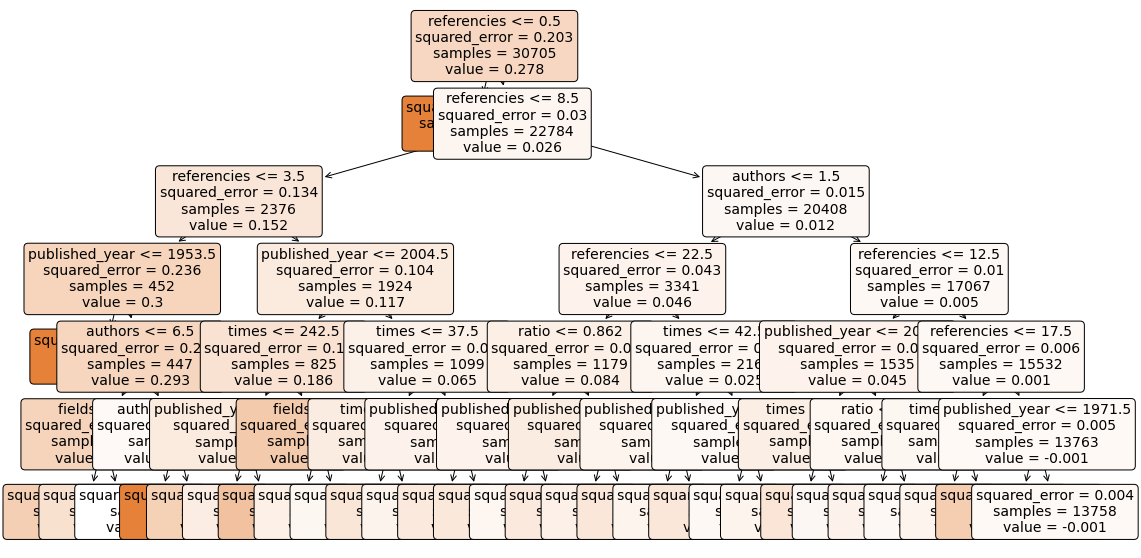

In [85]:
from sklearn import tree
plt.figure(figsize=(18, 10))
_ = tree.plot_tree(tree_cdindex, 
                   feature_names=X_train.columns,
                   filled=True, rounded=True, fontsize=14)

* This plot is a littple haotic 
* We will represent out tree with anothe represenation to be more clear the ifelse conditions.

In [86]:
feature_names = list(X_train.columns)
print(tree.export_text(tree_cdindex, feature_names=feature_names))

|--- referencies <= 0.50
|   |--- value: [1.00]
|--- referencies >  0.50
|   |--- referencies <= 8.50
|   |   |--- referencies <= 3.50
|   |   |   |--- published_year <= 1953.50
|   |   |   |   |--- value: [1.00]
|   |   |   |--- published_year >  1953.50
|   |   |   |   |--- authors <= 6.50
|   |   |   |   |   |--- fields <= 2.50
|   |   |   |   |   |   |--- value: [0.35]
|   |   |   |   |   |--- fields >  2.50
|   |   |   |   |   |   |--- value: [0.20]
|   |   |   |   |--- authors >  6.50
|   |   |   |   |   |--- authors <= 15.50
|   |   |   |   |   |   |--- value: [-0.05]
|   |   |   |   |   |--- authors >  15.50
|   |   |   |   |   |   |--- value: [1.00]
|   |   |--- referencies >  3.50
|   |   |   |--- published_year <= 2004.50
|   |   |   |   |--- times <= 242.50
|   |   |   |   |   |--- published_year <= 1968.50
|   |   |   |   |   |   |--- value: [0.33]
|   |   |   |   |   |--- published_year >  1968.50
|   |   |   |   |   |   |--- value: [0.10]
|   |   |   |   |--- times >  24

* The above represenation helps us to explain why a predicted value is equal to a value. 
    * The interpretation stemming from followig the ifelse conditions. 
* We will evaluate our model using the **ΜΑΕ (Mean Absolute Error)**. 
* By definition, a good values for mean absolute error is close to **0**.

In [87]:
predicted = tree_cdindex.predict(X_test)
print(metrics.mean_absolute_error(predicted,y_test))

0.040038349362138695


* We observe that 0.040 is a good value. 
* Now, we will calculate **R squared score** for both training and testing. 
* If scre.training > score.testing then it is an insight of overfitting (if the diffrence is mow then there is not overifitting).


In [88]:
print('Score Testing :: ', tree_cdindex.score(X_test, y_test))
print('Score Training ::', tree_cdindex.score(X_train, y_train))

Score Testing ::  0.9084004742106727
Score Training :: 0.9090789337112124


* So, the score is very good and we can observe that there is not overfitting. 

In [89]:
scores = cross_val_score(tree_cdindex, X_test.values, y_test.values, cv=10)
mean_score = np.mean(scores)
mean_score

0.9011388645744074

In [90]:
scores = cross_val_score(tree_cdindex, X_train.values, y_train.values, cv=10)
mean_score = np.mean(scores)
mean_score

0.9028377792887996

* We will see the importance featured in order.

In [91]:
X_train.columns

Index(['published_year', 'ratio', 'referencies', 'refer', 'fields', 'authors',
       'times'],
      dtype='object')

In [92]:
tree_cdindex.feature_importances_

array([3.02008988e-03, 2.09104647e-04, 9.91738264e-01, 0.00000000e+00,
       1.09460078e-03, 1.33115760e-03, 2.60678318e-03])

In [93]:
l = tree_cdindex.feature_importances_
l.tolist()

[0.003020089884493911,
 0.00020910464677754715,
 0.9917382639121531,
 0.0,
 0.001094600780034527,
 0.0013311575971915873,
 0.0026067831793492344]

In [94]:
# create dictionary 
dict_features = {'published_year':0.0030200898844939253,
                'ratio':  0.00020910464677754745,
                'referencies': 0.9917382639121537,
                'refer': 0.000,  
                'fields': 0.0010946007800345361,
                'authors': 0.0013311575971909086,
                'times':0.0026067831793493267}
# sort ascending order so read it in descending order 
{k: v for k, v in sorted(dict_features.items(), key=lambda item: item[1])}

{'refer': 0.0,
 'ratio': 0.00020910464677754745,
 'fields': 0.0010946007800345361,
 'authors': 0.0013311575971909086,
 'times': 0.0026067831793493267,
 'published_year': 0.0030200898844939253,
 'referencies': 0.9917382639121537}

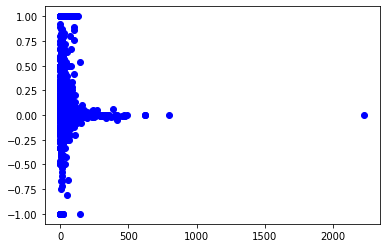

In [95]:
# referencies if too high 
xx = X['referencies']
yy = y
# see correlation 
import matplotlib.pyplot as plt
plt.scatter(xx, yy,c ="blue")
# To show the plot
plt.show()

* We applied this graph to see if there is a correlation betwwen the cdindex and referencies to try to explain why this feature referencies paly so important role.

Text(0, 0.5, 'counter of rows (df)')

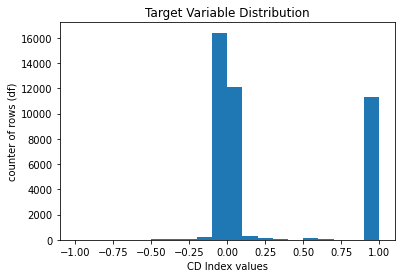

In [96]:
# We will see the distibution of the imbalanced data 
import matplotlib.pyplot as plt 
plt.hist(all['cdindex'], bins=20)
plt.title("Target Variable Distribution")
plt.xlabel('CD Index values')
plt.ylabel('counter of rows (df)')

* We can observe that the **most** important features is **referencies**.
    * We observe that the refrencies is extremely important (**~99%**). Ouaou!
    * We tried to explain this phenomenon bearing in mind the represenation of the tree (ifelse rules) and the distibution of scatterplot between cdindex and referencies, and the scatterplot of the distibution of cdindex.
    * The data are imbalanced, the majority of data are close to 0 and 1. Maybe the combination of imbalanced data may play a role to the important feature.
    * At this point we will point out that imbalanced data for regression model is under researh and there is not so straightforwar tecnhique to face them by constact wit hclassification problems that exist many techiques like SMOTE etc. 
    * We observed that the other features play a role only for the prediction of **cdindex** != 1. 
    * Cdindex equal with is predicted only from referencies (`referencies <= 0.50`). 
    * Howver, the good for using decision tree is that we can explain how we prredict a cdindex value becuse we can read the ifelse paths.
* The socond feature in order is : **times** (that is how many papers have written in tota per year and field)
* The third feature in order is : **published year** (it is logic since cdindex based on year by definition).    

## Random Forest Regression 

* We will run RandomForestRegressor regression as another approach to see if MAE will be decreased.

In [97]:
# search for the best depth of the random tree regressor 
parameters = [{'max_depth': list(range(1, 15))},]
cv = KFold(n_splits=5, shuffle=True, random_state=13)
clf = GridSearchCV(RandomForestRegressor(), parameters, cv=cv)
clf = clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_params_)

RandomForestRegressor(max_depth=9)
{'max_depth': 9}


* We wil run the random forest for the depth of : 
* We will calculare MAE and R-squared for both training and testing (check for overfitting).

In [98]:
regr = RandomForestRegressor(max_depth=8, random_state=3)
regr.fit(X_train, y_train)
scores = cross_val_score(regr, X_test, y_test, cv=5)
print(scores.mean())
predicted = regr.predict(X_test)
print('MAE',mean_absolute_error(predicted, y_test))
print('Test Score',regr.score(X_test, y_test))
print('Training Score',regr.score(X_train, y_train)) # it has overfitting .. 

0.9063200002803221
MAE 0.039829981718608375
Test Score 0.9114819967613413
Training Score 0.9240493277463092


* MAE **0.039** is a little better than Decision Tree (**0.040**).
* We don't have overfitting as test score (`R-Squared`) **~0.91** and training score (`R-squared`) **~0.92** 

In [99]:
X_train.columns

Index(['published_year', 'ratio', 'referencies', 'refer', 'fields', 'authors',
       'times'],
      dtype='object')

In [100]:
l2 = regr.feature_importances_

In [101]:
l2

array([0.00580089, 0.00373822, 0.9769667 , 0.00105548, 0.00227861,
       0.00235906, 0.00780105])

* Aagin we observe that the dominant feature is **referencies** (~97%!!!). 

In [102]:
scores = cross_val_score(regr, X_test.values, y_test.values, cv=10)
mean_score = np.mean(scores)
mean_score

0.9079251996326325

In [103]:
scores = cross_val_score(regr, X_train.values, y_train.values, cv=10)
mean_score = np.mean(scores)
mean_score

0.9088277695019435

- Concusions :
* More or less we have the same results with Decision Tree Regressor with a very little decrese in MAE. 
* The dominant important feature remain **referencies**.

## Tree-Based Advanced Algorithms

* In this section, we will use power tree-based algorithms, and specifically:
    * [XGBoost](https://xgboost.readthedocs.io/en/stable/)
    * [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* The specific implementations are very strong and work well in practice.

## XBoost 

* We will start by creating an XGBoost Regressor.

In [104]:
xgbr = xgb.XGBRegressor()

* Let's get a base error estimation.

In [105]:
xgbr.fit(X_train, y_train)
simple_xgb_pred = xgbr.predict(X_test)
sklearn.metrics.mean_absolute_error(y_test, simple_xgb_pred)

0.04728665784384107

* In comparison, we Decision Trees is very high MAE. 
* We will try to improve it.

In [106]:
parameters = [
   {
    'booster': ['gbtree', 'dart'],
    'eta': [0.1, 0.3, 0.6],
    'gamma': [0.5, 3, 10, 20],
    'max_depth': [3, 6, 10]
   }
]

xgbr_random_grid = RandomizedSearchCV(xgbr, parameters, cv=5, scoring='neg_mean_absolute_error')
xgbr_random_grid.fit(X_train, y_train)
all_xgbr_r = xgbr_random_grid.best_estimator_
all_xgbr_r

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0.5,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

* Let's see how well this one performs at the test set.

In [107]:
all_xgbr_pred = all_xgbr_r.predict(X_test)
sklearn.metrics.mean_absolute_error(y_test, all_xgbr_pred)

0.04129563897842769

* The results seem pretty good.
* Howver, again with decision trees we have better results.
* With, RFE, with 6 features and removing the feature :: refer MAE was :: 0.042
    * So, removing features weill not help to the improvement of MAE. 

## LightGBM

* We will use a LightGBM Regressor next.
* Let's create it.

In [108]:
lgbmr = lgb.LGBMRegressor()

* Again we will get a base error for this estimator.

In [109]:
lgbmr.fit(X_train, y_train)
simple_lgbm_pred = lgbmr.predict(X_test)
sklearn.metrics.mean_absolute_error(y_test, simple_lgbm_pred)

0.042005038260278606

* This is very promising MAE.
* Let's do our Grid Search to try to improve it more.

In [110]:
parameters = [
  {
   'boosting_type': ['gbdt', 'dart'],
   'num_leaves': [10, 31, 60, 90],
   'max_depth': [-1, 5 , 6 , 8, 9, 10],
   'learning_rate': [0.05, 0.1, 0.2, 0.3]
  }
]

lgbmr_grid = GridSearchCV(lgbmr, parameters, cv=5, scoring='neg_mean_absolute_error')
lgbmr_grid.fit(X_train, y_train)
all_lgbmr_r = lgbmr_grid.best_estimator_
all_lgbmr_r

LGBMRegressor(learning_rate=0.05)

* And have a look at how well it performs.

In [111]:
all_lgbmr_pred = all_lgbmr_r.predict(X_test)
sklearn.metrics.mean_absolute_error(y_test, all_lgbmr_pred)

0.04170994931116755

* Good MAE, bur MAE of random forest is better (0.039)

In [112]:
print(all_lgbmr_r.feature_name_)
print(all_lgbmr_r.feature_importances_)

['published_year', 'ratio', 'referencies', 'refer', 'fields', 'authors', 'times']
[738 508 584  61 190 242 677]


* Here feature importance are in diffrent. Order in comparison wihth previous trees: 
1. `published year` :: 738 
2. `times` :: 677 
3. `rerfrencies` :: 584
* In addition, we see taht therei not only one feature dominant.
* Again `refer` is not important.

* MAE has improved, however MAE with Decsion - Random Trees is better. 
* In addition, we applied tries with RFE bur MAE remained agin close to ~0.41 (out feature refer), so the situation was not improved in comparison with first previous trees.  

## Conlusions For Non Neural Network Machine Learning

* The best results were achieved with the **Random Forest Regressor**.
* Decision Tree Regressor is very close with Random Forest Classifier.
* The Minimum Absolute Error for the test set was: on average **0.039**.
* As far as the important features in trees for decision tree and random tree the  dominant feature with about 97% is **refrencies**. Then follows times and publish year. But for LGBMRegressor, we have the same 3 features having the highest importance from the whole 7 features but the refrencies is not domianant, times and published year are close to refrencies. 
* Now, as far as, if thsese features are logic to be important we would say that yes they are logic since in cdindex of course play role the year (cdindex --> 5 year window), times is calculated bearing in mind per **year** and per field how many papers in total have written. Finally, as far as the refrencie we would say taht stemming that the number of refrencies play role to cdindex which is not related to the year. 

* So, as conclusion, the best model is Random Forest, with important features: 

1. `refrencies` <br>
2.`times`<br>
3. `published year`<br>


* The features we would say that are not so surprising, since cd index as far as the calculation based on the year (five years window).



## Another Approach

## Target Variable Distribution

* We will repeat the graph for imbalanced (target value). 

Text(0, 0.5, 'counter of rows (df)')

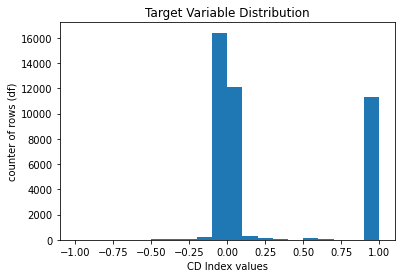

In [113]:
import matplotlib.pyplot as plt 
plt.hist(y, bins=20)
plt.title("Target Variable Distribution")
plt.xlabel('CD Index values')
plt.ylabel('counter of rows (df)')

* We can observe that our data are quite imbalanced. There are many values close to 0 and 1. But, this is a problem.

## Transform problem from Regression to Classification 

* We wil create **3** bins with the same step.
* The Bins are the following ones: 

* Meaning of the new assignments : 
    * [-1 : -0.33] : -1 :: `Low`
    * (-0.33 : 0.33] : 0 :: `Medium`
    * (-0.33 : 1] : 1 :: `High`
* We decided these bind because we will have emany data at least for the classesnamed :: `Medium`, `Low`.    
* This means that our classification model will predict if the **cdindex** is **-1** ,**0**, **1**. 
* For example, if the output of the model is (the prediction) -1 then it means that the cdindex takes a value from the range (-1 : -0.33], in other words we would say that is `Low`. 
* So, this is the logic behind this transormation and this is because we want to overcome the problem of the imbalanced data distribution. Since, Reading externa sources and papers, I concluded that imbalanced data for regression is under research and so We desided to try this approah of mapping cdindex values to bins, and converting regression problem to classification problem.
    * Classification problems have many techiques to overcomae tyhe problem of imbalanced data.
* In addition, we followed a piece of logic ffrom this nice [jupyter](https://l.messenger.com/l.php?u=https%3A%2F%2Fwww.kaggle.com%2Fcode%2Fprashant111%2Fdecision-tree-classifier-tutorial&h=AT3L-_Ylw1RGsM4L_UcyLEdKMdSiNjntuqPpUgGxTXom6ZpsFE0ZoZ7Es8Lqoq7q-zt_8TYV7Z8FCQZcrlCXG_ygNL7Te4X9CYj8yhH5bBU1td88hrVzCrMx5Ko1B_RrM3u8B75rmUBicfNda1xQag) 
* So, to start with this approach, we will create our x,y and then we will create the bins that we said. 
* Not, for X features we sellect all features since trying havinf 6 or 5 features using RFE we had not significant improvemnt. 

In [114]:
classifier_3_X = all[['published_year','ratio','referencies',
                    'refer','fields','authors','times']] 
classifier_3_X

,published_year,ratio,referencies,refer,fields,authors,times
0,1946,1.000000,0,0.0,2,1,2
1,1947,1.000000,9,0.0,5,4,5
2,1947,0.968254,11,0.0,2,2,2
3,1948,1.000000,0,1.0,2,1,4
4,1948,0.880000,4,0.0,1,1,1
...,...,...,...,...,...,...,...
40936,2017,0.940000,38,0.0,1,11,60
40937,2017,0.833333,44,0.0,2,8,218
40938,2017,0.845238,43,0.0,1,3,3
40939,2017,0.936000,21,0.0,3,8,331


In [115]:
classifier_3_y = all[['cdindex']]
classifier_3_y

,cdindex
0,1.000000
1,0.000000
2,-0.071429
3,1.000000
4,1.000000
...,...
40936,0.000000
40937,-0.003106
40938,0.002105
40939,-0.013514


In [116]:
classifier_3_y.assign(stage=pd.cut(classifier_3_y.cdindex, bins=[-1,-0.33,0.33,1], labels=[-1,0,1]))
classifier_3_y.cdindex = classifier_3_y.cdindex.astype(int)
classifier_3_y

,cdindex
0,1
1,0
2,0
3,1
4,1
...,...
40936,0
40937,0
40938,0
40939,0


* Let's see the new distribution stemming from our convertion of regression problem to classification problem.

Text(0, 0.5, 'counter of rows (df)')

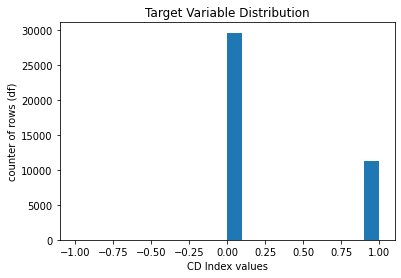

In [117]:
import matplotlib.pyplot as plt 
plt.hist(classifier_3_y['cdindex'], bins=20)
plt.title("Target Variable Distribution")
plt.xlabel('CD Index values')
plt.ylabel('counter of rows (df)')

* We will split our data to trainig and testing (30%). 

In [118]:
# we will split the dataset 
y = classifier_3_y['cdindex']
X = classifier_3_X 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1234)
print(X_train.shape, y_train.shape)

(28658, 7) (28658,)


* We will apply **SMOTE** for overcoming Imbalanced cdindex values.

In [119]:
# Source: https://imbalanced-learn.org/stable/over_sampling.html
# Source: https://stackoverflow.com/questions/49395939/smote-initialisation-expects-n-neighbors-n-samples-but-n-samples-n-neighbo (for the passed parameter **k**)
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train) # we apply resampling only for the training set 
print(sorted(Counter(y_resampled).items()))

[(-1, 20714), (0, 20714), (1, 20714)]


* Now, we observe that each class consist of **20659** values.
* Now, we will apply a GridSearch for finding the best parameters so as we tune our model.

In [120]:
from sklearn.tree import DecisionTreeClassifier
parameters = {
     'criterion': ['gini', 'entropy'],
     'max_depth': [1,2,3,4,5,6]
}

clf = GridSearchCV(DecisionTreeClassifier(), parameters)

clf = clf.fit(X_resampled, y_resampled)
print(clf.best_estimator_)
print(clf.best_params_)

DecisionTreeClassifier(max_depth=6)
{'criterion': 'gini', 'max_depth': 6}


In [121]:
# instantiate the DecisionTreeClassifier model with criterion gini index
clf_gini = DecisionTreeClassifier(max_depth=6,
                                  criterion = 'gini',
                                  random_state=0)
# fit the model
clf_gini.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=6, random_state=0)

In [122]:
y_pred_gini = clf_gini.predict(X_test)

In [123]:
from sklearn.metrics import accuracy_score
print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))

Model accuracy score with criterion gini index: 0.9232


In [124]:
y_pred_train_gini = clf_gini.predict(X_resampled)
y_pred_train_gini

array([0, 0, 0, ..., 1, 1, 1])

In [125]:
print('Training set score: {:.4f}'.format(clf_gini.score(X_resampled, y_resampled)))
print('Test set score: {:.4f}'.format(clf_gini.score(X_test, y_test)))

Training set score: 0.9480
Test set score: 0.9232


* We observe that our model don't have overfitting since the diffrence between training score and test score is small (about ~0.02).

In [126]:
# Confusion matrics 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_gini)
print('Confusion matrix\n\n', cm)

Confusion matrix

 [[   4    5    0]
 [ 688 8186   15]
 [  96  139 3150]]


* Let's print confusion matrix in a better appearance.

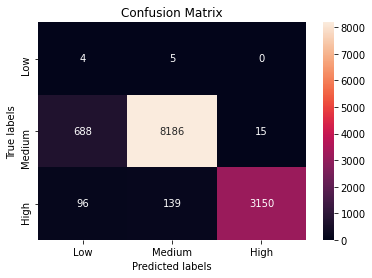

In [127]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Low', 'Medium','High']); ax.yaxis.set_ticklabels(['Low', 'Medium','High']);

* We observe that our classifier predicts very well the Medium class that is cdindex values range from -0.33 to 0.33.
* In addition, we observe that our classifier predicts very well the High class that is cdindex values range from 0.33 to 1.
* However, it cannot predict the low class taht is cdindex values range from -1 to -0.33, which is logic on account of the low number of data we have only very few samples!!.

In [128]:
# evaluation report 
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_gini))

              precision    recall  f1-score   support

          -1       0.01      0.44      0.01         9
           0       0.98      0.92      0.95      8889
           1       1.00      0.93      0.96      3385

    accuracy                           0.92     12283
   macro avg       0.66      0.77      0.64     12283
weighted avg       0.99      0.92      0.95     12283



* We can observe that our model have high values in the metrics for classes **0** (Medium), **1** (High)

* The reason why we converting our regression problem to classification was because we wanted to do somethig for the imbalanced data.
* The classifier model because it is general since from the range [-1,1]:: continuous values predict a general result if it low, medium,high plays a supportive role as a debugging tool for our regression models.
* In addition, it may be useful, if a user want to know if the cdindex may bo medium or high (general idea). 

## PLEASE, PAY ATTENTION :: THE NEURAL NETWORK FOR REGRESSION IS IN DIFFRENT JUPYTER NOTEBOOK
## JUPYTER NAME :: Neural Network 
*This is because we run it in Google Colab 